# S2SHIPS Dataset Analysis and Processing
This notebook provides utilities for analyzing and processing the S2SHIPS dataset, which contains Sentinel-2 satellite imagery of ports and corresponding ship segmentation masks.

## Dataset Structure
- **Image Data**: Sentinel-2 satellite images with 12 spectral bands
  - Resolution: 938 x 1783 pixels
  - Bands include: Coastal, Blue, Green, Red, Red Edge (1-3), NIR, NIR Narrow, Water Vapor, SWIR Cirrus, SWIR 1 (short-wave infrared)
- **Mask Data**: Segmentation masks stored in .npy format
  - Contains both raw spectral data (`data`) and segmentation labels (`label`)
  - Data shape: (938, 1783, 12) - corresponds to the 12 Sentinel-2 bands
  - Label shape: (938, 1783) - binary segmentation mask for ships, indicating ship presence with 1 and background with 0

In [32]:
# Import necessary libraries
import os
import io
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        PIL.Image: Preprocessed image
    """
    # Load image
    img = Image.open(image_path)

    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize image
    img = img.resize(target_size, Image.Resampling.LANCZOS)

    return img

In [54]:
# Define constants and paths
BASE_DIR = "E:/Datasets/S2SHIPS/"
NUM_BANDS = 12
FILE_STRUCTURE = {
    "ports": f"{BASE_DIR}/dataset_tif",
    "masks": f"{BASE_DIR}dataset_npy",
}

ports_path = FILE_STRUCTURE["ports"]
ports_lst = list()

for folder_name in os.listdir(ports_path):
    folder_path = os.path.join(ports_path, folder_name)
    if os.path.isdir(folder_path):
        ports_lst.append(folder_name)
print(f"Ports: {ports_lst}")

Ports: ['brest1', 'marseille', 'panama', 'portsmouth', 'rome', 'rotterdam1', 'rotterdam2', 'rotterdam3', 'southampton', 'suez1', 'suez2', 'suez3', 'suez4', 'suez5', 'suez6', 'toulon']


In [55]:
image_data = {}

for folder_name in os.listdir(ports_path):
    folder_path = os.path.join(ports_path, folder_name)
    if os.path.isdir(folder_path):
        image_data[folder_name] = {"ndwi": [], "water": [], "rgb": []}

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            if file_name.endswith(".png"):
                if "ndwi" in file_name:
                    image_data[folder_name]["ndwi"].append(cv2.imread(file_path, cv2.IMREAD_UNCHANGED))
                elif "water" in file_name:
                    image_data[folder_name]["water"].append(cv2.imread(file_path, cv2.IMREAD_UNCHANGED))
                elif "rgb" in file_name:
                    image_data[folder_name]["rgb"].append(cv2.imread(file_path, cv2.IMREAD_UNCHANGED))

In [56]:
mask_data = {}
masks_dir = FILE_STRUCTURE["masks"]
print(f"Loading masks from: {masks_dir}")

for file_name in os.listdir(masks_dir):
    if file_name.endswith('.npy'):
        try:
            file_path = os.path.join(masks_dir, file_name)
            mask_data[file_name] = np.load(file_path, allow_pickle=True)
            print(f"Successfully loaded: {file_name}")
        except Exception as e:
            print(f"Error loading {file_name}: {str(e)}")

Loading masks from: E:/Datasets/S2SHIPS/dataset_npy
Successfully loaded: 01_mask_rome.npy
Successfully loaded: 02_mask_suez1.npy
Successfully loaded: 03_mask_suez2.npy
Successfully loaded: 04_mask_suez3.npy
Successfully loaded: 05_mask_suez4.npy
Successfully loaded: 06_mask_suez5.npy
Successfully loaded: 07_mask_suez6.npy
Successfully loaded: 08_mask_brest1.npy
Successfully loaded: 09_mask_panama.npy
Successfully loaded: 10_mask_toulon.npy
Successfully loaded: 11_mask_marseille.npy
Successfully loaded: 12_mask_portsmouth.npy
Successfully loaded: 13_mask_rotterdam1.npy
Successfully loaded: 14_mask_rotterdam2.npy
Successfully loaded: 15_mask_rotterdam3.npy
Successfully loaded: 16_mask_southampton.npy


In [76]:
# Load the .npy file
data_dict = np.load(masks_dir + '/01_mask_rome.npy', allow_pickle=True).item()  # Ensure it's treated as a dictionary

# Extract the Sentinel-2 image (12 spectral bands)
image_bands = data_dict["data"]  # Shape: (938, 1783, 12)

# Extract the segmentation mask
segmentation_mask = data_dict["label"]  # Shape: (938, 1783, 1)

# Remove extra dimension from mask for easier processing
segmentation_mask = segmentation_mask.squeeze()  # Shape: (938, 1783)

# Print shapes to verify
print("Image Bands Shape:", image_bands.shape)  # (938, 1783, 12)
print("Segmentation Mask Shape:", segmentation_mask.shape)  # (938, 1783)


Image Bands Shape: (938, 1783, 12)
Segmentation Mask Shape: (938, 1783)


## Data Visualization and Analysis

### Understanding the Data Structure
- **Spectral Bands**: The dataset provides 12 Sentinel-2 bands for each image.
  - Each band captures specific wavelengths of light.
  - Different bands are suited for various types of analysis, such as water detection, vegetation analysis, or atmospheric correction.

### Visualization Components
1. **Binary Segmentation Mask**
   - Visualizes the ship segmentation labels.
   - White (1): Indicates detected ship locations.
   - Black (0): Represents background or water.

2. **Spectral Bands Visualization**
   - Displays all 12 Sentinel-2 bands individually, showcasing their spectral information.
   - Bands are normalized to the [0,1] range to enhance visualization clarity.
   - A 'jet' colormap is used to display intensity variations across pixels for each band.

These visual insights are vital for understanding the dataset's structure and evaluating the segmentation performance while leveraging the rich spectral data for analysis.

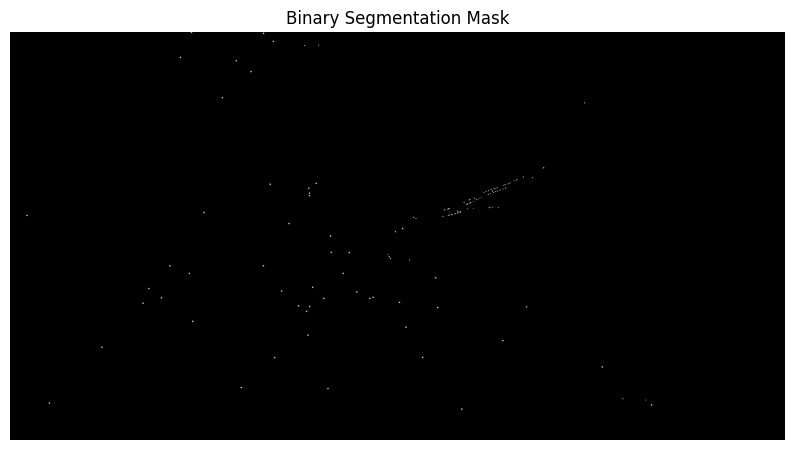

In [81]:
# Display the label channel
segmentation_mask = data_dict["label"].squeeze()  # Remove extra dimension

# Convert to binary: All nonzero values become 1 (ships)
binary_mask = (segmentation_mask > 0).astype(np.uint8)

# Display the binary mask
plt.figure(figsize=(10, 6))
plt.imshow(binary_mask, cmap="gray")  # 'gray' makes 0 = black, 1 = white
plt.title("Binary Segmentation Mask")
plt.axis("off")
plt.show()

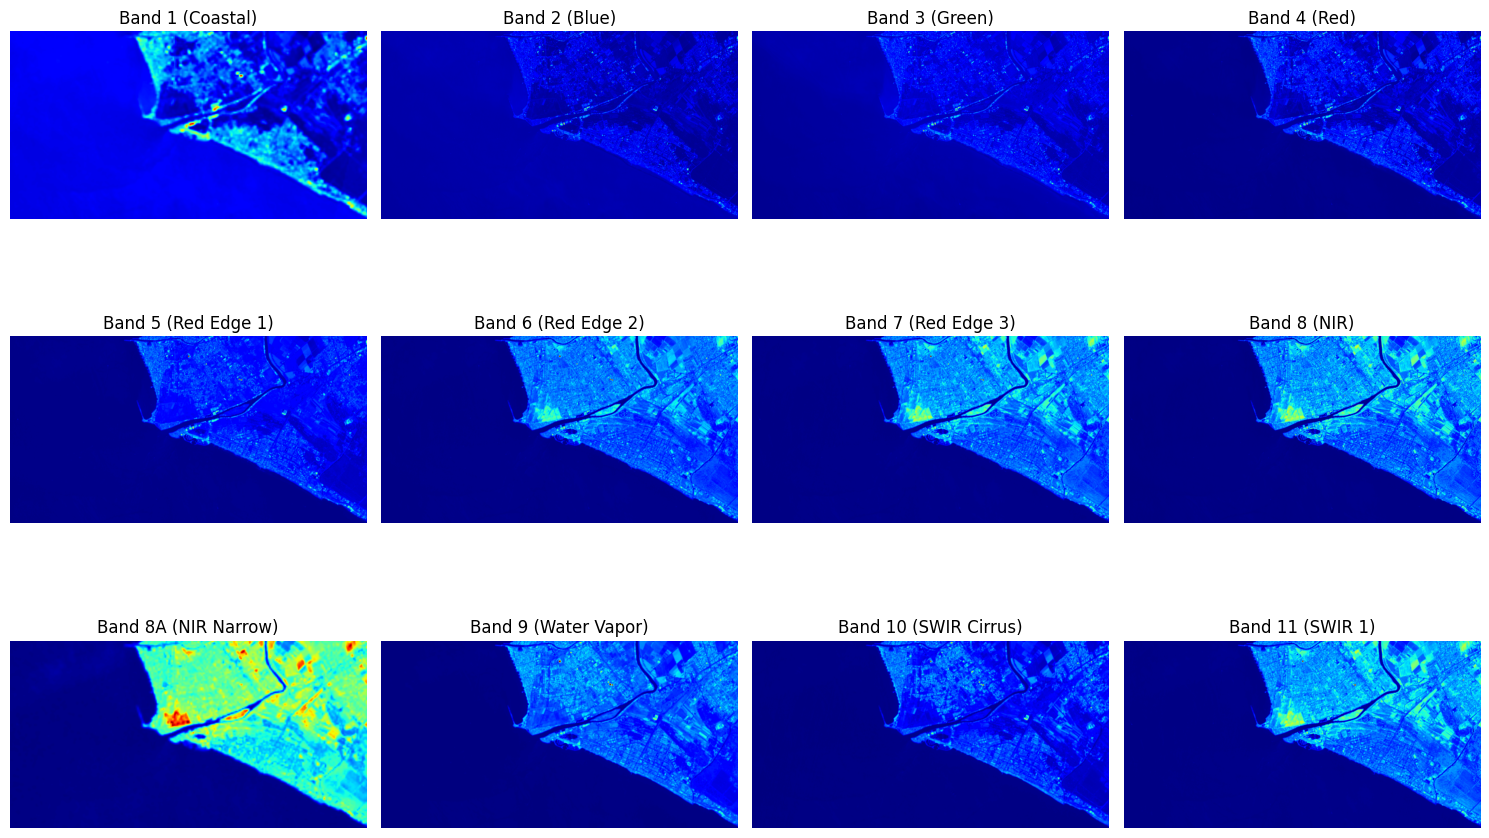

In [84]:
# Normalize between 0 and 1 for high reflective values
image_bands = image_bands / image_bands.max()

# Sentinel-2 band names for reference
band_names = [
    "Band 1 (Coastal)", "Band 2 (Blue)", "Band 3 (Green)", "Band 4 (Red)",
    "Band 5 (Red Edge 1)", "Band 6 (Red Edge 2)", "Band 7 (Red Edge 3)",
    "Band 8 (NIR)", "Band 8A (NIR Narrow)", "Band 9 (Water Vapor)",
    "Band 10 (SWIR Cirrus)", "Band 11 (SWIR 1)"
]

# Plot each band in a 3x4 grid
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(image_bands[..., i], cmap="jet")  # Display each band in grayscale
    axes[i].set_title(band_names[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

